In [21]:
using DifferentialEquations
using Plots
using LaTeXStrings
pgfplotsx()

Plots.PGFPlotsXBackend()

Consider the simple reaction:

\begin{align}
    A + * &\longleftrightarrow A_*\\
    A_*   &\longleftrightarrow B + *\\
\end{align}

Both are elementary steps that occur in the liquid phase, and we will consider it in a few different solvent environments.  For this case, both reactions happen on similar time scales, and we'll consider the impact of solvation on degree of rate control.

In [22]:
function tCSTR(du, u, p, t)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k10, k20, K10, K20, FAf, FBf, FS = PAR

    FA       = FAf
    thetaA   = u[:,1]
    FB       = FBf

    FT     = FA + FB + FS
    
    XA   = FA/FT
    XB   = FB/FT
    XS   = FS/FT
    
    thetastar = 1.0 .- thetaA
    
    #For A in solvent
    A12A = MAR[1]

    #For As in solvent
    A12As = MAR[2]
    
    #For B in solvent
    A12B = MAR[3]
    
    #For Transition State 1 in solvent
    A12TS1 = MAR[4]
    
    #For Transition State 2 in solvent
    A12TS2 = MAR[5]

    gammaA  = exp.(XS.^2*A12A)
    gammaAs = exp.(XS.^2*A12As)
    gammaB  = exp.(XS.^2*A12B)

    gammaTS1 = exp.(XS.^2*A12TS1)
    gammaTS2 = exp.(XS.^2*A12TS2)

    z1 = 1/K10*gammaAs./gammaA.*thetaA./XA./thetastar
    z2 = 1/K20*gammaB./gammaAs.*XB.*thetastar./thetaA

    r1 = k10*gammaA./gammaTS1.*XA.*thetastar.*(1 .- z1)
    r2 = k20*gammaAs./gammaTS2.*thetaA.*(1 .- z2)

    r2[isnan.(r2)] .= 0
    
    RAs =  r1[1] .- r2[1]
    
    du[1] = RAs
    return du, r1, r2, z1, z2
end

tCSTR (generic function with 1 method)

In [23]:
function rate(p)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k10, k20, K10, K20, FAf, FBf, FS = PAR

    FA       = FAf
    FB       = FBf

    FT     = FA + FB + FS
    
    XA   = FA/FT
    XB   = FB/FT
    XS   = FS/FT
    
    #For A in solvent
    A12A = MAR[1]

    #For As in solvent
    A12As = MAR[2]
    
    #For B in solvent
    A12B = MAR[3]
    
    #For Transition State 1 in solvent
    A12TS1 = MAR[4]
    
    #For Transition State 2 in solvent
    A12TS2 = MAR[5]

    gammaA  = exp.(XS.^2*A12A)
    gammaAs = exp.(XS.^2*A12As)
    gammaB  = exp.(XS.^2*A12B)

    gammaTS1 = exp.(XS.^2*A12TS1)
    gammaTS2 = exp.(XS.^2*A12TS2)

    rate = k10*k20*gammaA*gammaAs/gammaTS1/gammaTS2*XA/(k10/K10*gammaAs/gammaTS1 + k20*gammaAs/gammaTS2 + k10*gammaA/gammaTS1*XA)
    
    return rate
end

rate (generic function with 1 method)

In [24]:
function DRC(p)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k10, k20, K10, K20, FAf, FBf, FS = PAR

    FA       = FAf
    FB       = FBf

    FT     = FA + FB + FS
    
    XA   = FA/FT
    XB   = FB/FT
    XS   = FS/FT
    
    #For A in solvent
    A12A = MAR[1]

    #For As in solvent
    A12As = MAR[2]
    
    #For B in solvent
    A12B = MAR[3]
    
    #For Transition State 1 in solvent
    A12TS1 = MAR[4]
    
    #For Transition State 2 in solvent
    A12TS2 = MAR[5]

    gammaA  = exp.(XS.^2*A12A)
    gammaAs = exp.(XS.^2*A12As)
    gammaB  = exp.(XS.^2*A12B)

    gammaTS1 = exp.(XS.^2*A12TS1)
    gammaTS2 = exp.(XS.^2*A12TS2)

    DRCval = k20/k10*gammaAs/gammaTS2/(1/K10*gammaAs/gammaTS1 + k20/k10*gammaAs/gammaTS2 + gammaA/gammaTS1*XA)
    
    return DRCval
end

DRC (generic function with 1 method)

In [25]:
K    = 1
Ns   = 0.0001
k10  = 0.10000
k20  = 100
K10  = 0.001
K20  = K/K10
V    = 1
FTOT = 100
tau  = 0.001

FAf     = 0.1
thetaA0 = 0.0
FBf     = 0.0

FS   = FTOT - FAf - FBf

var0     = [thetaA0]
span     = (0.0, 1000);

In [26]:
MARSET = zeros(5,)
MARVALS = range(-4, stop = 4, length = 50)

tfine  = range(0.0, stop = maximum(span), length = 1000)
r1out  = zeros(length(tfine), length(MARVALS), 5)
r2out  = zeros(length(tfine), length(MARVALS), 5)
z1out  = zeros(length(tfine), length(MARVALS), 5)
z2out  = zeros(length(tfine), length(MARVALS), 5)
cov    = zeros(length(tfine), length(MARVALS), 5)
XRC1out = zeros(length(MARVALS), 5)
XRC2out = zeros(length(MARVALS), 5)
#rSSout  = zeros(length(MARVALS), 5)
#XRC1SS  = zeros(length(MARVALS), 5)
#XRCA    = zeros(length(MARVALS), 5)

for j = 1:5
    MARSET    = zeros(5,)
    for i = 1:length(MARVALS)
        MARSET[j] = MARVALS[i]
        p0   = Dict("MAR" => MARSET, "PAR" => [k10, k20, K10, K20, FAf, FBf, FS])
        prob = ODEProblem(tCSTR, var0, span, p0)
        sol  = solve(prob, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solf = sol(tfine)
        thetaA  = solf[1,:]

        dut, rt1, rt2, zt1, zt2 = tCSTR([0.], thetaA, p0, tfine)

        cov[:, i, j]  = thetaA
        r1out[:, i, j] = rt1
        r2out[:, i, j] = rt2
        z1out[:, i, j] = zt1
        z2out[:, i, j] = zt2
        

        p1        = Dict("MAR" => MARSET, "PAR" => [1.0001*k10, k20, K10, K20, FAf, FBf, FS])
        p2        = Dict("MAR" => MARSET, "PAR" => [k10, 1.0001*k20, K10, K20, FAf, FBf, FS])
        pert1     = ODEProblem(tCSTR, var0, span, p1)
        pert2     = ODEProblem(tCSTR, var0, span, p2)
        solp1     = solve(pert1, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp1f    = solp1(tfine)
        thetaAp1  = solp1f[1,:]
        solp2     = solve(pert2, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp2f    = solp2(tfine)
        thetaAp2  = solp2f[1,:]

        dut1, rt11, rt21, zt11, zt21 = tCSTR([0.], thetaAp1, p1, tfine)
        dut2, rt12, rt22, zt12, zt22 = tCSTR([0.], thetaAp2, p2, tfine)
#       rSSout0  = rate(p0)
#       rSSout1  = rate(p1)
#       rSSout2  = rate(p2)
        
        
        XRC1  = k10/0.0001/k10*(rt21[end] - rt2[end])/rt2[end]
        XRC2  = k20/0.0001/k20*(rt22[end] - rt2[end])/rt2[end]
#       XRCSS = k10/0.0001/k10*(rSSout1 - rSSout0)/rSSout0
        XRC1out[i, j] = XRC1
        XRC2out[i, j] = XRC2
#       XRC1SS[i, j]  = XRCSS
#       XRCA[i, j]    = DRC(p0)
    end
end

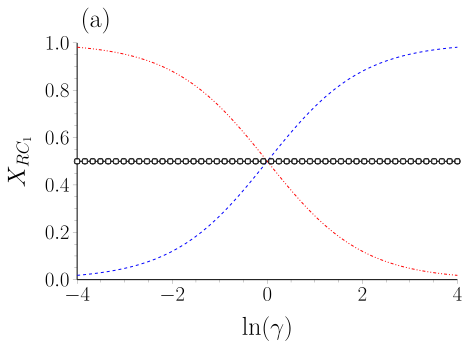

In [27]:
plt1 = plot(
    xlim    = (-4, 4),
    xminorticks = 4,
    ylim = (0, 1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel = L"\textrm{ln}(\gamma)",
    ylabel  = L"X_{RC_1}", 
    fontfamily = "Times Roman",
    legendfontsize = 12,
    legend  = nothing,
    title = "(a)",
    titlelocation = :left,
    titlefontsize = 26
)

plt1 = plot!(plt1, MARVALS, XRC1out[:,1:2], lc = :white, markercolor = :white, markersize = [4 3], markershape = [:circle :square], labels = ["Solvate A" "Solvate A*"])
plt1 = plot!(plt1, MARVALS, XRC1out[:,3],   lc = :black,       ls = :solid,              lw = 1.0, label = "Solvate B")
plt1 = plot!(plt1, MARVALS, XRC1out[:,4:5], lc = [:blue :red], ls = [:dash :dashdotdot], lw = 1.0, labels = ["Solvate TS1" "Solvate TS2"])

display(plt1)
savefig(plt1, "CS41.pdf")

In [28]:
K    = 1
Ns   = 0.0001
k10  = 1e3
k20  = 1
K10  = 1e6
K20  = K/K10
V    = 1
FTOT = 100
tau  = 0.001

FAf     = 0.1
thetaA0 = 0.0
FBf     = 0.0

FS   = FTOT - FAf - FBf

var0     = [thetaA0]
span     = (0.0, 1000);

In [29]:
MARSET = zeros(5,)
MARVALS = range(-4, stop = 4, length = 50)

tfine  = range(0.0, stop = maximum(span), length = 1000)
r1out  = zeros(length(tfine), length(MARVALS), 5)
r2out  = zeros(length(tfine), length(MARVALS), 5)
z1out  = zeros(length(tfine), length(MARVALS), 5)
z2out  = zeros(length(tfine), length(MARVALS), 5)
cov    = zeros(length(tfine), length(MARVALS), 5)
XRC1out = zeros(length(MARVALS), 5)
XRC2out = zeros(length(MARVALS), 5)

for j = 1:5
    MARSET    = zeros(5,)
    for i = 1:length(MARVALS)
        MARSET[j] = MARVALS[i]
        p0   = Dict("MAR" => MARSET, "PAR" => [k10, k20, K10, K20, FAf, FBf, FS])
        prob = ODEProblem(tCSTR, var0, span, p0)
        sol  = solve(prob, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solf = sol(tfine)
        thetaA  = solf[1,:]

        dut, rt1, rt2, zt1, zt2 = tCSTR([0.], thetaA, p0, tfine)

        cov[:, i, j]  = thetaA
        r1out[:, i, j] = rt1
        r2out[:, i, j] = rt2
        z1out[:, i, j] = zt1
        z2out[:, i, j] = zt2

        p1        = Dict("MAR" => MARSET, "PAR" => [1.0001*k10, k20, K10, K20, FAf, FBf, FS])
        p2        = Dict("MAR" => MARSET, "PAR" => [k10, 1.0001*k20, K10, K20, FAf, FBf, FS])
        pert1     = ODEProblem(tCSTR, var0, span, p1)
        pert2     = ODEProblem(tCSTR, var0, span, p2)
        solp1     = solve(pert1, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp1f    = solp1(tfine)
        thetaAp1  = solp1f[1,:]
        solp2     = solve(pert2, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp2f    = solp2(tfine)
        thetaAp2  = solp2f[1,:]

        dut1, rt11, rt21, zt11, zt21 = tCSTR([0.], thetaAp1, p1, tfine)
        dut2, rt12, rt22, zt12, zt22 = tCSTR([0.], thetaAp2, p2, tfine)
        XRC1  = k10/0.0001/k10*(rt21[end] - rt2[end])/rt2[end]
        XRC2  = k20/0.0001/k20*(rt22[end] - rt2[end])/rt2[end]
        XRC1out[i, j] = XRC1
        XRC2out[i, j] = XRC2
    end
end

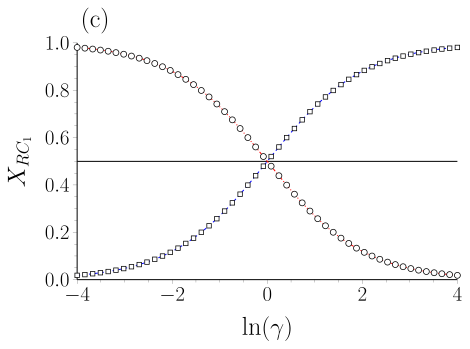

In [30]:
plt2 = plot(
    xlim    = (-4, 4),
    xminorticks = 4,
    ylim = (0, 1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel = L"\textrm{ln}(\gamma)",
    ylabel  = L"X_{RC_1}", 
    fontfamily = "Times Roman",
    legendfontsize = 12,
    legend  = nothing,
    title = "(c)",
    titlelocation = :left,
    titlefontsize = 26
)

plt2 = plot!(plt2, MARVALS, XRC1out[:,1:2], lc = :white, markercolor = :white, markersize = [4 3], markershape = [:circle :square], labels = ["Solvate A" "Solvate A*"])
plt2 = plot!(plt2, MARVALS, XRC1out[:,3],   lc = :black,       ls = :solid,              lw = 1.0, label = "Solvate B")
plt2 = plot!(plt2, MARVALS, XRC1out[:,4:5], lc = [:blue :red], ls = [:dash :dashdotdot], lw = 1.0, labels = ["Solvate TS1" "Solvate TS2"])
display(plt2)
savefig(plt2, "CS42.pdf")

In [31]:
K    = 1
Ns   = 0.0001
k10  = 166.5
k20  = 1
K10  = 200
K20  = K/K10
V    = 1
FTOT = 100
tau  = 0.001

FAf     = 0.1
thetaA0 = 0.0
FBf     = 0.0

FS   = FTOT - FAf - FBf

var0     = [thetaA0]
span     = (0.0, 1000);

In [32]:
MARSET = zeros(5,)
MARVALS = range(-4, stop = 4, length = 50)

tfine  = range(0.0, stop = maximum(span), length = 1000)
r1out  = zeros(length(tfine), length(MARVALS), 5)
r2out  = zeros(length(tfine), length(MARVALS), 5)
z1out  = zeros(length(tfine), length(MARVALS), 5)
z2out  = zeros(length(tfine), length(MARVALS), 5)
cov    = zeros(length(tfine), length(MARVALS), 5)
XRC1out = zeros(length(MARVALS), 5)
XRC2out = zeros(length(MARVALS), 5)

for j = 1:5
    MARSET    = zeros(5,)
    for i = 1:length(MARVALS)
        MARSET[j] = MARVALS[i]
        p0   = Dict("MAR" => MARSET, "PAR" => [k10, k20, K10, K20, FAf, FBf, FS])
        prob = ODEProblem(tCSTR, var0, span, p0)
        sol  = solve(prob, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solf = sol(tfine)
        thetaA  = solf[1,:]

        dut, rt1, rt2, zt1, zt2 = tCSTR([0.], thetaA, p0, tfine)

        cov[:, i, j]  = thetaA
        r1out[:, i, j] = rt1
        r2out[:, i, j] = rt2
        z1out[:, i, j] = zt1
        z2out[:, i, j] = zt2

        p1        = Dict("MAR" => MARSET, "PAR" => [1.0001*k10, k20, K10, K20, FAf, FBf, FS])
        p2        = Dict("MAR" => MARSET, "PAR" => [k10, 1.0001*k20, K10, K20, FAf, FBf, FS])
        pert1     = ODEProblem(tCSTR, var0, span, p1)
        pert2     = ODEProblem(tCSTR, var0, span, p2)
        solp1     = solve(pert1, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp1f    = solp1(tfine)
        thetaAp1  = solp1f[1,:]
        solp2     = solve(pert2, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp2f    = solp2(tfine)
        thetaAp2  = solp2f[1,:]

        dut1, rt11, rt21, zt11, zt21 = tCSTR([0.], thetaAp1, p1, tfine)
        dut2, rt12, rt22, zt12, zt22 = tCSTR([0.], thetaAp2, p2, tfine)
        XRC1  = k10/0.0001/k10*(rt21[end] - rt2[end])/rt2[end]
        XRC2  = k20/0.0001/k20*(rt22[end] - rt2[end])/rt2[end]
        XRC1out[i, j] = XRC1
        XRC2out[i, j] = XRC2
    end
end

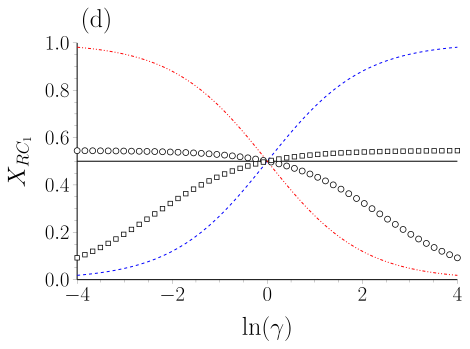

In [33]:
plt3 = plot(
    xlim    = (-4, 4),
    xminorticks = 4,
    ylim = (0, 1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel = L"\textrm{ln}(\gamma)",
    ylabel  = L"X_{RC_1}", 
    fontfamily = "Times Roman",
    legendfontsize = 12,
    legend  = nothing,
    title = "(d)",
    titlelocation = :left,
    titlefontsize = 26
)

plt3 = plot!(plt3, MARVALS, XRC1out[:,1:2], lc = :white, markercolor = :white, markersize = [4 3], markershape = [:circle :square], labels = ["Solvate A" "Solvate A*"])
plt3 = plot!(plt3, MARVALS, XRC1out[:,3],   lc = :black,       ls = :solid,              lw = 1.0, label = "Solvate B")
plt3 = plot!(plt3, MARVALS, XRC1out[:,4:5], lc = [:blue :red], ls = [:dash :dashdotdot], lw = 1.0, labels = ["Solvate TS1" "Solvate TS2"])
display(plt3)
savefig(plt3, "CS43.pdf")

In [34]:
K    = 1
Ns   = 0.0001
k10  = 835
k20  = 1
K10  = 5000
K20  = K/K10
V    = 1
FTOT = 100
tau  = 0.001

FAf     = 0.1
thetaA0 = 0.0
FBf     = 0.0

FS   = FTOT - FAf - FBf

var0     = [thetaA0]
span     = (0.0, 1000);

In [35]:
MARSET = zeros(5,)
MARVALS = range(-4, stop = 4, length = 50)

tfine  = range(0.0, stop = maximum(span), length = 1000)
r1out  = zeros(length(tfine), length(MARVALS), 5)
r2out  = zeros(length(tfine), length(MARVALS), 5)
z1out  = zeros(length(tfine), length(MARVALS), 5)
z2out  = zeros(length(tfine), length(MARVALS), 5)
cov    = zeros(length(tfine), length(MARVALS), 5)
XRC1out = zeros(length(MARVALS), 5)
XRC2out = zeros(length(MARVALS), 5)

for j = 1:5
    MARSET    = zeros(5,)
    for i = 1:length(MARVALS)
        MARSET[j] = MARVALS[i]
        p0   = Dict("MAR" => MARSET, "PAR" => [k10, k20, K10, K20, FAf, FBf, FS])
        prob = ODEProblem(tCSTR, var0, span, p0)
        sol  = solve(prob, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solf = sol(tfine)
        thetaA  = solf[1,:]

        dut, rt1, rt2, zt1, zt2 = tCSTR([0.], thetaA, p0, tfine)

        cov[:, i, j]  = thetaA
        r1out[:, i, j] = rt1
        r2out[:, i, j] = rt2
        z1out[:, i, j] = zt1
        z2out[:, i, j] = zt2

        p1        = Dict("MAR" => MARSET, "PAR" => [1.0001*k10, k20, K10, K20, FAf, FBf, FS])
        p2        = Dict("MAR" => MARSET, "PAR" => [k10, 1.0001*k20, K10, K20, FAf, FBf, FS])
        pert1     = ODEProblem(tCSTR, var0, span, p1)
        pert2     = ODEProblem(tCSTR, var0, span, p2)
        solp1     = solve(pert1, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp1f    = solp1(tfine)
        thetaAp1  = solp1f[1,:]
        solp2     = solve(pert2, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp2f    = solp2(tfine)
        thetaAp2  = solp2f[1,:]

        dut1, rt11, rt21, zt11, zt21 = tCSTR([0.], thetaAp1, p1, tfine)
        dut2, rt12, rt22, zt12, zt22 = tCSTR([0.], thetaAp2, p2, tfine)
        XRC1  = k10/0.0001/k10*(rt21[end] - rt2[end])/rt2[end]
        XRC2  = k20/0.0001/k20*(rt22[end] - rt2[end])/rt2[end]
        XRC1out[i, j] = XRC1
        XRC2out[i, j] = XRC2
    end
end

# display(XRC1out)

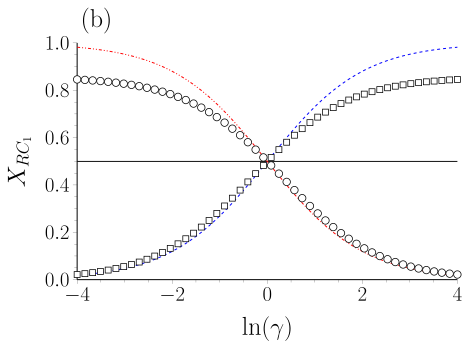

In [36]:
plt4 = plot(
    xlim    = (-4, 4),
    xminorticks = 4,
    ylim = (0, 1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel = L"\textrm{ln}(\gamma)",
    ylabel  = L"X_{RC_1}", 
    fontfamily = "Times Roman",
    legendfontsize = 12,
    legend  = nothing,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 26
)

plt4 = plot!(plt4, MARVALS, XRC1out[:,1:2], lc = :white, markercolor = :white, markersize = [5 4], markershape = [:circle :square], labels = ["Solvate A" "Solvate A*"])
plt4 = plot!(plt4, MARVALS, XRC1out[:,3],   lc = :black,       ls = :solid,              lw = 1.0, label = "Solvate B")
plt4 = plot!(plt4, MARVALS, XRC1out[:,4:5], lc = [:blue :red], ls = [:dash :dashdotdot], lw = 1.0, labels = ["Solvate TS1" "Solvate TS2"])
display(plt4)
savefig(plt4, "CS44.pdf")

In [37]:
K    = 1
Ns   = 0.0001
k10  = 1e-4
k20  = 1
K10  = 1
K20  = K/K10
V    = 1
FTOT = 100
tau  = 0.001

FAf     = 0.1
thetaA0 = 0.0
FBf     = 0.0

FS   = FTOT - FAf - FBf

var0     = [thetaA0]
span     = (0.0, 1000);

In [38]:
MARSET = zeros(5,)
MARVALS = range(-4, stop = 4, length = 50)

tfine  = range(0.0, stop = maximum(span), length = 1000)
r1out  = zeros(length(tfine), length(MARVALS), 5)
r2out  = zeros(length(tfine), length(MARVALS), 5)
z1out  = zeros(length(tfine), length(MARVALS), 5)
z2out  = zeros(length(tfine), length(MARVALS), 5)
cov    = zeros(length(tfine), length(MARVALS), 5)
XRC1out = zeros(length(MARVALS), 5)
XRC2out = zeros(length(MARVALS), 5)

for j = 1:5
    MARSET    = zeros(5,)
    for i = 1:length(MARVALS)
        MARSET[j] = MARVALS[i]
        p0   = Dict("MAR" => MARSET, "PAR" => [k10, k20, K10, K20, FAf, FBf, FS])
        prob = ODEProblem(tCSTR, var0, span, p0)
        sol  = solve(prob, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solf = sol(tfine)
        thetaA  = solf[1,:]

        dut, rt1, rt2, zt1, zt2 = tCSTR([0.], thetaA, p0, tfine)

        cov[:, i, j]  = thetaA
        r1out[:, i, j] = rt1
        r2out[:, i, j] = rt2
        z1out[:, i, j] = zt1
        z2out[:, i, j] = zt2

        p1        = Dict("MAR" => MARSET, "PAR" => [1.0001*k10, k20, K10, K20, FAf, FBf, FS])
        p2        = Dict("MAR" => MARSET, "PAR" => [k10, 1.0001*k20, K10, K20, FAf, FBf, FS])
        pert1     = ODEProblem(tCSTR, var0, span, p1)
        pert2     = ODEProblem(tCSTR, var0, span, p2)
        solp1     = solve(pert1, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp1f    = solp1(tfine)
        thetaAp1  = solp1f[1,:]
        solp2     = solve(pert2, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solp2f    = solp2(tfine)
        thetaAp2  = solp2f[1,:]

        dut1, rt11, rt21, zt11, zt21 = tCSTR([0.], thetaAp1, p1, tfine)
        dut2, rt12, rt22, zt12, zt22 = tCSTR([0.], thetaAp2, p2, tfine)
        XRC1  = k10/0.0001/k10*(rt21[end] - rt2[end])/rt2[end]
        XRC2  = k20/0.0001/k20*(rt22[end] - rt2[end])/rt2[end]
        XRC1out[i, j] = XRC1
        XRC2out[i, j] = XRC2
    end
end

# display(XRC1out)

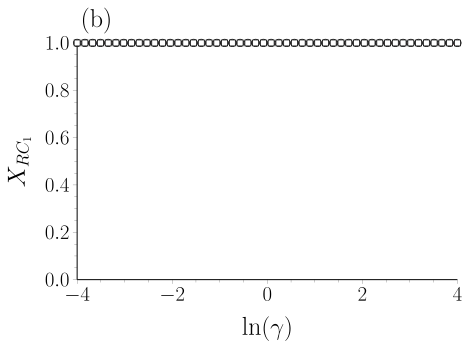

In [39]:
plt5 = plot(
    xlim    = (-4, 4),
    xminorticks = 4,
    ylim = (0, 1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel = L"\textrm{ln}(\gamma)",
    ylabel  = L"X_{RC_1}", 
    fontfamily = "Times Roman",
    legendfontsize = 12,
    legend  = nothing,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 26
)

plt5 = plot!(plt5, MARVALS, XRC1out[:,1:2], lc = :white, markercolor = :white, markersize = [5 4], markershape = [:circle :square], labels = ["Solvate A" "Solvate A*"])
plt5 = plot!(plt5, MARVALS, XRC1out[:,3],   lc = :black,       ls = :solid,              lw = 1.0, label = "Solvate B")
plt5 = plot!(plt5, MARVALS, XRC1out[:,4:5], lc = [:blue :red], ls = [:dash :dashdotdot], lw = 1.0, labels = ["Solvate TS1" "Solvate TS2"])
display(plt5)
savefig(plt5, "CS45.pdf")